In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

# Gen-level Wqq vs GenLep

In [9]:
outdir = "/Users/fmokhtar/Desktop/AN_2024/L2/"

In [37]:
df = pd.read_parquet(glob.glob("L2/outfiles_nolepinjet/0-20_*.parquet"))
df_AN = pd.read_parquet(glob.glob("L2/outfiles_AN/0-20_*.parquet"))

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

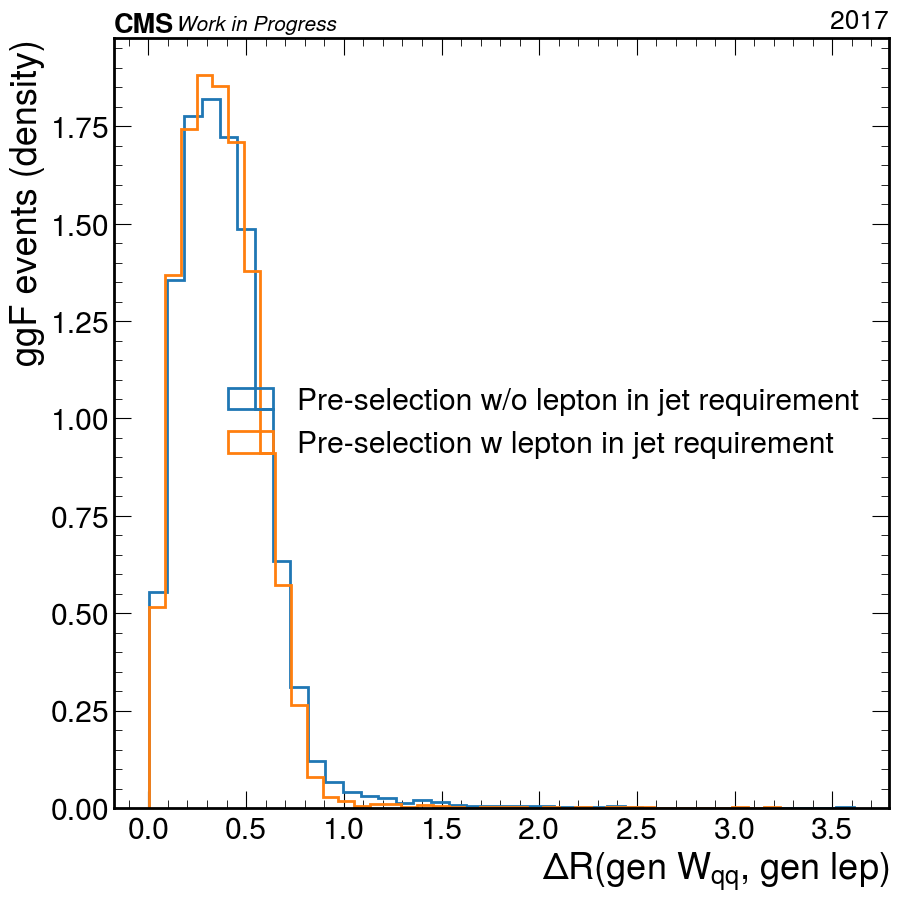

In [40]:
fig, ax = plt.subplots(figsize=(10,10))

ax.hist(
    df["dR_genVhad_genlep"],
    bins=40,
    histtype="step",
    lw=2,
    label="Pre-selection w/o lepton in jet requirement",
    density=True,
)


ax.hist(
    df_AN["dR_genVhad_genlep"],
    bins=40,
    histtype="step",
    lw=2,
    label="Pre-selection w lepton in jet requirement",
    density=True,    
)

ax.set_xlabel(r"$\Delta$R(gen $W_{qq}$, gen lep)")
ax.set_ylabel("ggF events (density)")

ax.legend()

hep.cms.lumitext("2017", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

# plt.savefig(f"{outdir}/dR_gen_Wqq_lep.pdf")

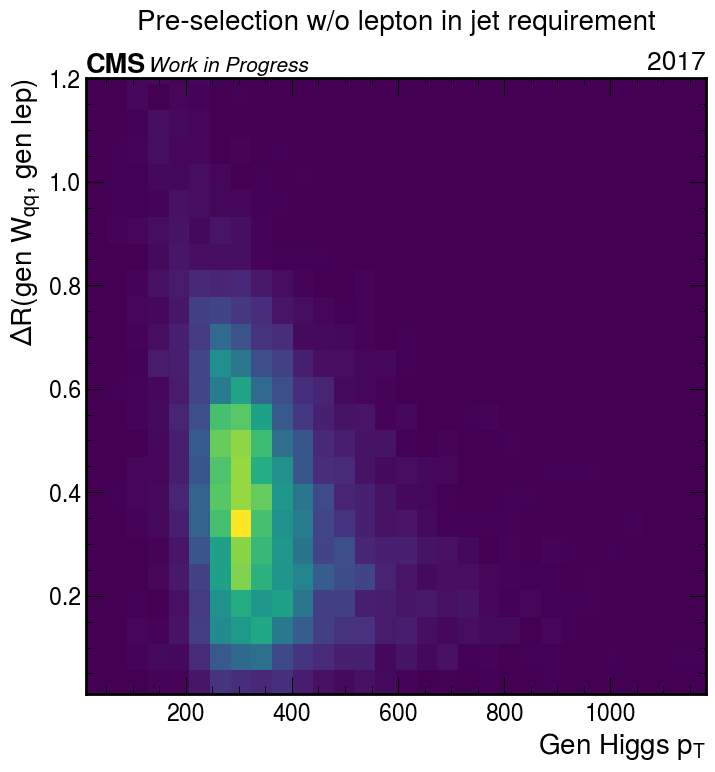

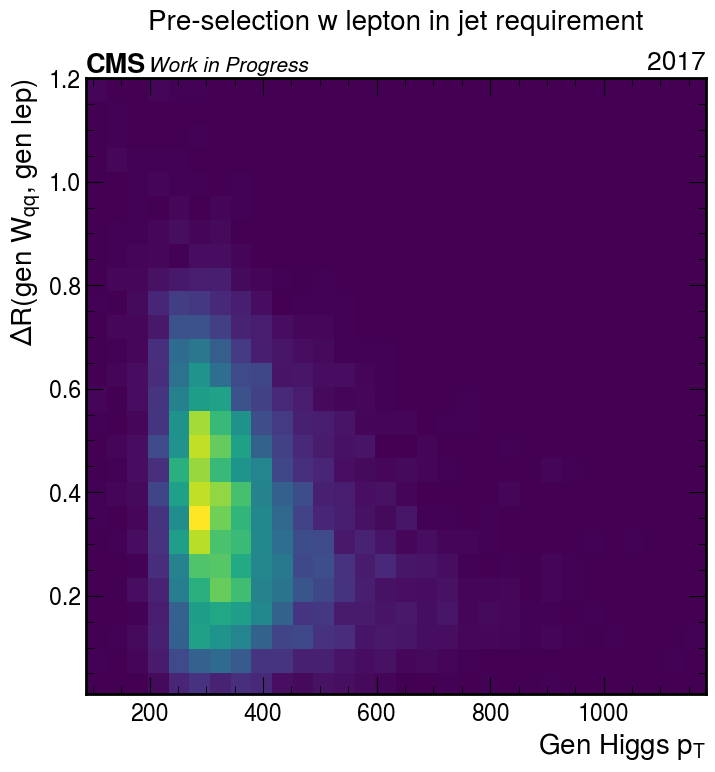

In [12]:
fig, ax = plt.subplots(figsize=(8,8))

msk = (~df["dR_genVhad_genlep"].isnull())

ax.hist2d(
    df["fj_genRes_pt"][msk],
    df["dR_genVhad_genlep"][msk],
    bins=(30,70),
)

ax.set_title("Pre-selection w/o lepton in jet requirement", pad=35, fontsize=20)

ax.set_xlabel(r"Gen Higgs $p_T$")
ax.set_ylabel(r"$\Delta$R(gen $W_{qq}$, gen lep)")

ax.set_ylim(0.01,1.2)

hep.cms.lumitext("2017", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.savefig(f"{outdir}/dR_gen_Wqq_lep_2d_without.pdf")

# -----------------

fig, ax = plt.subplots(figsize=(8,8))

msk = (~df_AN["dR_genVhad_genlep"].isnull())

ax.hist2d(
    df_AN["fj_genRes_pt"][msk],
    df_AN["dR_genVhad_genlep"][msk],
    bins=(30,70),
)

ax.set_title("Pre-selection w lepton in jet requirement", pad=35, fontsize=20)

ax.set_xlabel(r"Gen Higgs $p_T$")
ax.set_ylabel(r"$\Delta$R(gen $W_{qq}$, gen lep)")

ax.set_ylim(0.01,1.2)

hep.cms.lumitext("2017", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.savefig(f"{outdir}/dR_gen_Wqq_lep_2d_with.pdf")

In [15]:
import argparse
import json
import os
import pickle as pkl
import sys
import time
import warnings
from typing import Union

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import uproot
from coffea import nanoevents, processor
from coffea.nanoevents import BaseSchema, NanoAODSchema, NanoEventsFactory
from coffea.nanoevents.methods.nanoaod import FatJetArray, GenParticleArray

sys.path.append("../")

import json
import os
import pathlib
import pickle as pkl
import shutil
import warnings
from collections import defaultdict
from typing import List, Optional

import awkward as ak
import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from coffea import processor
from coffea.analysis_tools import PackedSelection, Weights
from coffea.nanoevents.methods import candidate, vector

warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid="ignore")

# load a hww root file into coffea-friendly NanoAOD structure
import uproot
f = uproot.open(f"../rootfiles/HWW/file1.root")

num = f['Events'].num_entries   ### checks number of events per file 
print(f'number of events per file is {num}')

events = nanoevents.NanoEventsFactory.from_root(f, "Events").events()
events

/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/numba/cpython/hashing.py:482: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


number of events per file is 15000


<NanoEventsArray [<event 1:100:99001>, ... ] type='15000 * event'>

In [16]:
def get_pid_mask(
    genparts: GenParticleArray,
    pdgids: Union[int, list],
    ax: int = 2,
    byall: bool = True,
) -> ak.Array:
    """
    Get selection mask for gen particles matching any of the pdgIds in ``pdgids``.
    If ``byall``, checks all particles along axis ``ax`` match.
    """
    gen_pdgids = abs(genparts.pdgId)

    if type(pdgids) is list:
        mask = gen_pdgids == pdgids[0]
        for pdgid in pdgids[1:]:
            mask = mask | (gen_pdgids == pdgid)
    else:
        mask = gen_pdgids == pdgids

    return ak.all(mask, axis=ax) if byall else mask


def to_label(array: ak.Array) -> ak.Array:
    return ak.values_astype(array, np.int32)

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]


genparts = events.GenPart
HIGGS_PDGID = 25

higgs = genparts[get_pid_mask(genparts, HIGGS_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)]

In [23]:
d_PDGID = 1
c_PDGID = 4
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

GAMMA_PDGID = 22
Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25

PI_PDGID = 211
PO_PDGID = 221
PP_PDGID = 111

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

FILL_NONE_VALUE = -99999

JET_DR = 0.8


genparts = events.GenPart
    
higgs = genparts[get_pid_mask(genparts, HIGGS_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)]

# get the higgs closest to jet
matched_higgs = ak.firsts(higgs)
matched_higgs_children = matched_higgs.children
higgs_children = higgs.children

genVars = {"fj_genH_pt": ak.fill_none(higgs.pt, FILL_NONE_VALUE)}

children_mask = get_pid_mask(matched_higgs_children, [W_PDGID], byall=False)

children_all_mask = get_pid_mask(ak.firsts(higgs).children, [W_PDGID], byall=False)
is_decay = ak.any(children_all_mask, axis=1)

# order by mass, select lower mass child as V* and higher as V
matched_higgs_children = matched_higgs_children[children_mask]
children_mass = matched_higgs_children.mass
v_star = ak.firsts(matched_higgs_children[ak.argmin(children_mass, axis=1, keepdims=True)])
v = ak.firsts(matched_higgs_children[ak.argmax(children_mass, axis=1, keepdims=True)])

# VV daughters
# requires coffea-0.7.21
all_daus = higgs_children.distinctChildrenDeep
all_daus = ak.flatten(all_daus, axis=2)
all_daus_flat = ak.flatten(all_daus, axis=2)
all_daus_flat_pdgId = abs(all_daus_flat.pdgId)

# the following tells you about the decay
num_quarks = ak.sum(all_daus_flat_pdgId <= b_PDGID, axis=1)
num_leptons = ak.sum(
    (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID),
    axis=1,
)
num_electrons = ak.sum(all_daus_flat_pdgId == ELE_PDGID, axis=1)
num_muons = ak.sum(all_daus_flat_pdgId == MU_PDGID, axis=1)
num_taus = ak.sum(all_daus_flat_pdgId == TAU_PDGID, axis=1)

# the following tells you about the matching
# # prongs except neutrino
# neutrinos = (
#     (all_daus_flat_pdgId == vELE_PDGID) | (all_daus_flat_pdgId == vMU_PDGID) | (all_daus_flat_pdgId == vTAU_PDGID)
# )
leptons = (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID)


lep_daughters = all_daus_flat[leptons]
# parent = ak.firsts(lep_daughters[fatjet.delta_r(lep_daughters) < JET_DR].distinctParent)
parent = ak.firsts(lep_daughters.distinctParent)
iswlepton = parent.mass == v.mass
iswstarlepton = parent.mass == v_star.mass

gen_lepton = ak.firsts(lep_daughters)

# identifying the leptonic gen V
Ws_children_pdgid = abs(matched_higgs_children.children.pdgId)
msk_isVlep = (Ws_children_pdgid == ELE_PDGID) | (Ws_children_pdgid == MU_PDGID) | (Ws_children_pdgid == TAU_PDGID)
msk_isVhad = ~msk_isVlep

genVlep = ak.firsts(matched_higgs_children[ak.singletons(ak.argmax(ak.sum(msk_isVlep, axis=-1), axis=-1))])
genVhad = ak.firsts(matched_higgs_children[ak.singletons(ak.argmax(ak.sum(msk_isVhad, axis=-1), axis=-1))])

genHVVVars = {
    # added on Oct 2, 2024
    "fj_genRes_pt": matched_higgs.pt,
    "genVhad_pt": genVhad.pt,
    "genVlep_pt": genVlep.pt,
    "dR_genVhad_genlep": genVhad.delta_r(gen_lepton),
    "dR_genVlep_genlep": genVlep.delta_r(gen_lepton),
}

/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/coffea/nanoevents/methods/nanoaod.py:107: UserWarning: distinctChildrenDeep may not give correct answers for all generators!
  warnings.warn(


In [137]:
msk_isVlep

<Array [[[False, False], ... [False, False]]] type='15000 * option[var * option[...'>

In [21]:
genHVVVars

{'fj_genRes_pt': <Array [283, 249, 240, 273, ... 270, 244, 347] type='15000 * ?float32[parameters...'>,
 'genVhad_pt': <Array [129, 66.5, 62.4, ... 134, 14.1, 117] type='15000 * ?float32[parameters={...'>,
 'genVlep_pt': <Array [154, 183, 62.4, ... 134, 14.1, 230] type='15000 * ?float32[parameters={"...'>,
 'dR_genVhad_genlep': <Array [0.118, 0.66, None, ... None, 1.35] type='15000 * ?float32'>,
 'dR_genVlep_genlep': <Array [0.32, 0.0753, None, ... None, 1.31] type='15000 * ?float32'>}

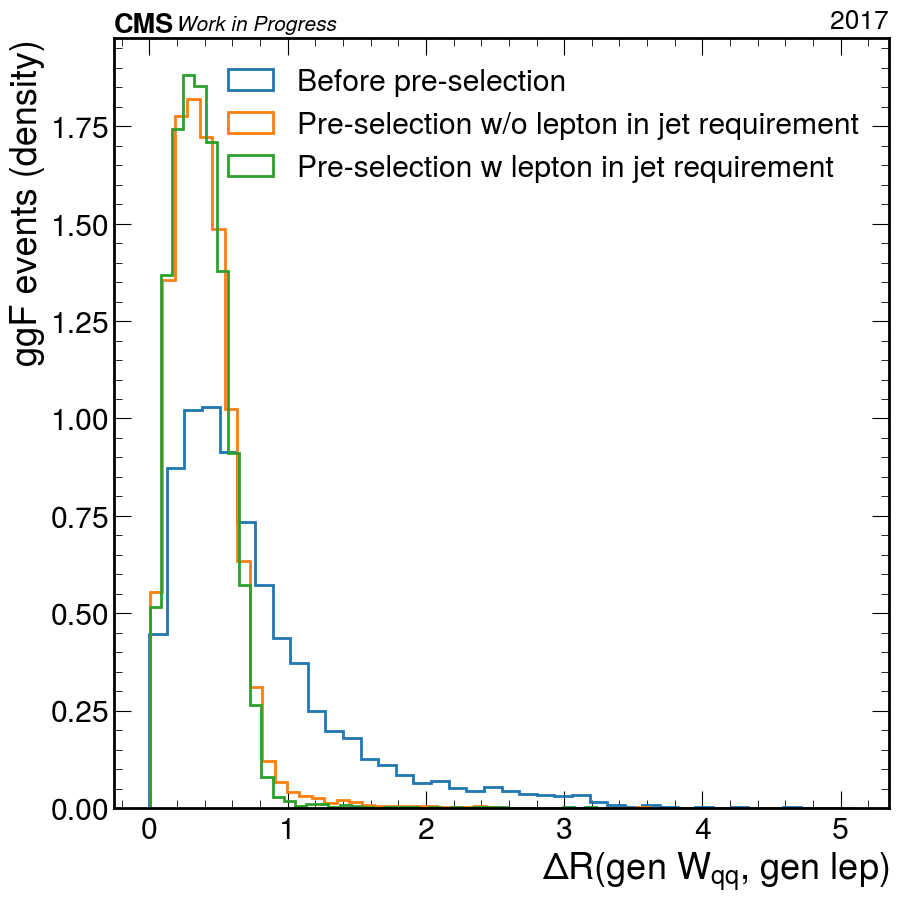

In [154]:
fig, ax = plt.subplots(figsize=(10,10))

ax.hist(
    ak.flatten(genHVVVars["dR_genVhad_genlep"], axis=0),
    bins=40,
    histtype="step",
    lw=2,
    label="Before pre-selection",
    density=True,    
)

ax.hist(
    df["dR_genVhad_genlep"],
    bins=40,
    histtype="step",
    lw=2,
    label="Pre-selection w/o lepton in jet requirement",
    density=True,    
)


ax.hist(
    df_AN["dR_genVhad_genlep"],
    bins=40,
    histtype="step",
    lw=2,
    label="Pre-selection w lepton in jet requirement",
    density=True,
)

ax.set_xlabel(r"$\Delta$R(gen $W_{qq}$, gen lep)")
ax.set_ylabel("ggF events (density)")

ax.legend()

hep.cms.lumitext("2017", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.savefig(f"{outdir}/dR_gen_Wqq_lep.pdf")

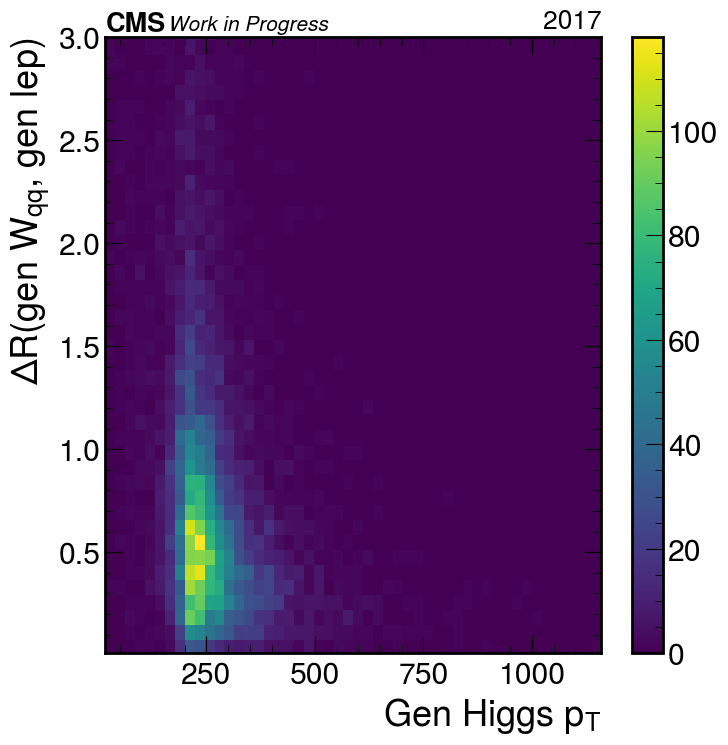

In [149]:
fig, ax = plt.subplots(figsize=(8,8))

msk = ~ak.is_none(genHVVVars["dR_genVhad_genlep"])

X = np.array(genHVVVars["fj_genRes_pt"][msk])
Y = np.array(ak.flatten(genHVVVars["dR_genVhad_genlep"], axis=0))
h = ax.hist2d(
    X,
    Y,
    bins=(50,70),
)

ax.set_xlabel(r"Gen Higgs $p_T$")
ax.set_ylabel(r"$\Delta$R(gen $W_{qq}$, gen lep)")

ax.set_ylim(0.01,3)

hep.cms.lumitext("2017", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

fig.colorbar(h[3], ax=ax)

plt.savefig(f"{outdir}/dR_gen_Wqq_lep_2d_before.pdf")

# -----------------

In [140]:
(Y > 0.8).sum() / len(Y)

0.3406420351302241